# Selection de variables avec le lasso

In [3]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
import re
import matplotlib.pyplot as plt
import pprint
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [5]:
from sklearn.linear_model import Lasso
#voir si besoin de standardiser les features


In [50]:
#importation des donnees
url_retards ='https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC'
retards = requests.get(url_retards)
wb_retards = retards.json()

df_retards = pd.DataFrame(wb_retards)
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,32,5.363539,9,4,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,None,193,7.294991,...,56,7.225734,29,11,37.333333,26.666667,21.333333,4.000000,9.333333,1.333333


In [51]:
#on retire les colonnes de commentaires qui sont generalement vides
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)

In [52]:
#on retire aussi les colonnes de NaN et dont les retards valent 0 qui ne nous interessent pas ici
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['nb_train_retard_arrivee']==0].index)

In [53]:
df_retards['cause_materiel_roulant'] = df_retards['prct_cause_materiel_roulant']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_infra'] = df_retards['prct_cause_infra']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_gestion_trafic'] = df_retards['prct_cause_gestion_trafic']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_externe'] = df_retards['prct_cause_externe']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_gestion_gare'] = df_retards['prct_cause_gestion_gare']/100*df_retards['nb_train_retard_arrivee']
df_retards['cause_prise_en_charge_voyageurs'] = df_retards['prct_cause_prise_en_charge_voyageurs']/100*df_retards['nb_train_retard_arrivee']
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,16.666667,16.666667,8.333333,3.333333,17.500000,36.750000,17.500000,21.000000,8.750000,3.500000
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,21.333333,4.000000,9.333333,1.333333,3.360000,22.400000,17.920000,31.360000,7.840000,1.120000
2,2018-01,National,PARIS MONTPARNASSE,ANGERS SAINT LAUD,90,385,3,49,8.362585,0.730105,...,21.428571,23.809524,9.523810,0.000000,12.380952,12.380952,11.142857,11.142857,4.952381,0.000000
3,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,15.384615,19.230769,0.000000,0.000000,5.000000,10.000000,4.000000,7.000000,0.000000,0.000000
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,19.298246,15.789474,1.754386,1.754386,14.052632,40.596491,17.175439,14.052632,1.561404,1.561404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,2022-08,National,PARIS MONTPARNASSE,NANTES,130,584,5,68,15.297059,1.453080,...,15.909091,22.727273,2.272727,15.909091,10.227273,1.022727,7.159091,18.409091,1.022727,7.159091
6933,2022-08,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,62,509,0,53,10.325786,0.677472,...,26.530612,42.857143,6.122449,12.244898,23.142857,5.510204,14.326531,1.102041,3.306122,6.612245
6934,2022-08,National,PARIS MONTPARNASSE,TOURS,74,167,0,16,12.529167,0.835529,...,16.666667,50.000000,8.333333,16.666667,7.500000,1.250000,2.500000,0.000000,1.250000,2.500000
6935,2022-08,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,169,119,0,34,4.072549,1.626754,...,28.571429,23.809524,0.000000,9.523810,5.000000,2.000000,6.000000,6.000000,0.000000,2.000000


In [54]:
#on copie la dataframe initiale par securite
df_retards_initial = df_retards.copy()
#df_retards = df_retards_initial.copy()
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,16.666667,16.666667,8.333333,3.333333,17.500000,36.750000,17.500000,21.000000,8.750000,3.500000
1,2018-01,National,NANTES,PARIS MONTPARNASSE,128,525,3,193,7.294991,2.720211,...,21.333333,4.000000,9.333333,1.333333,3.360000,22.400000,17.920000,31.360000,7.840000,1.120000
2,2018-01,National,PARIS MONTPARNASSE,ANGERS SAINT LAUD,90,385,3,49,8.362585,0.730105,...,21.428571,23.809524,9.523810,0.000000,12.380952,12.380952,11.142857,11.142857,4.952381,0.000000
3,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,37,9.501351,1.003981,...,15.384615,19.230769,0.000000,0.000000,5.000000,10.000000,4.000000,7.000000,0.000000,0.000000
4,2018-01,National,POITIERS,PARIS MONTPARNASSE,94,472,4,224,6.784673,3.229701,...,19.298246,15.789474,1.754386,1.754386,14.052632,40.596491,17.175439,14.052632,1.561404,1.561404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6932,2022-08,National,PARIS MONTPARNASSE,NANTES,130,584,5,68,15.297059,1.453080,...,15.909091,22.727273,2.272727,15.909091,10.227273,1.022727,7.159091,18.409091,1.022727,7.159091
6933,2022-08,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,62,509,0,53,10.325786,0.677472,...,26.530612,42.857143,6.122449,12.244898,23.142857,5.510204,14.326531,1.102041,3.306122,6.612245
6934,2022-08,National,PARIS MONTPARNASSE,TOURS,74,167,0,16,12.529167,0.835529,...,16.666667,50.000000,8.333333,16.666667,7.500000,1.250000,2.500000,0.000000,1.250000,2.500000
6935,2022-08,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,169,119,0,34,4.072549,1.626754,...,28.571429,23.809524,0.000000,9.523810,5.000000,2.000000,6.000000,6.000000,0.000000,2.000000


In [70]:
causes_retards = ['cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs', 'nb_train_prevu']
causes_retards_large = ['nb_annulation', 'nb_train_prevu', 'cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs']

In [71]:
features = df_retards[causes_retards]
features = StandardScaler().fit(features.values).transform(features.values)
df_retards[causes_retards] = features


In [72]:
x = sm.add_constant(df_retards[causes_retards_large])
y = df_retards[['nb_train_retard_arrivee']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)
xTest

,const,nb_annulation,nb_train_prevu,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
852,1.0,3,-0.513971,-0.502644,0.735619,1.341995,0.382833,0.208139,-0.107049
1127,1.0,3,0.041600,0.553081,0.863761,0.578926,0.530192,-0.217558,0.637381
825,1.0,0,0.029653,-0.332454,0.061590,-0.346468,-0.005892,-0.424046,0.418314
5158,1.0,0,0.077444,-0.333142,-0.426201,-0.472893,-0.222570,-0.092056,2.194662
5746,1.0,3,0.250686,1.148510,-0.149876,1.385845,-0.080614,0.632701,0.197662
...,...,...,...,...,...,...,...,...,...
6308,1.0,10,0.161078,-0.502644,-0.559653,-0.363269,-0.034687,1.173053,-0.598517
6615,1.0,0,-1.183045,-0.951327,-0.795157,-0.728683,-0.869725,-0.113499,-0.598517
6274,1.0,6,-0.251120,-0.609474,-0.778336,-0.572077,-0.631142,-0.756775,-0.598517
5334,1.0,1,1.397672,0.422765,0.649758,0.019908,-0.017290,-0.100097,1.659166


In [73]:
#on fait la regression lineaire

results = sm.OLS(yTrain, xTrain).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 4.298e+04
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        08:28:55   Log-Likelihood:                -14826.
No. Observations:                5424   AIC:                         2.967e+04
Df Residuals:                    5415   BIC:                         2.973e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     


**Analyse des coefficients**

Le R2 de la regression est de 98,3 ce qui est très satisfaisant (1 correspondant à une prédiction parfaite). Les varaibles cause_materiel_roulant, cause_infra, cause_gestion_trafic, cause_externe, cause_gestion_gare, cause_prise_en_charge_voyageurs sont significatives. Les variables nb_train_prevu et nb_annulation ne sont pas significatives. 
Le coefficient le plus élevé est celui des causes externes. Il signifie qu'une cause externe provoque le retard de 9,4 trains. On va utiliser le lasso pour sélectionner les variables.

In [84]:
#puis on predit les resultats
#yPred = sm.predict(xTrain)
yPred = results.predict(xTest)
epsilon = yTest - yPred

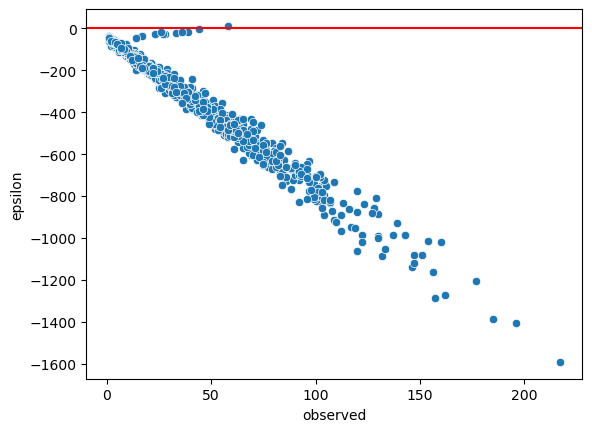

In [85]:
#Nuage de points des valeurs observées
tempdf = pd.DataFrame({"prediction": yPred, "observed": yTest,
                       "epsilon": yTest - yPred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "observed", y = "epsilon")
g.axhline(0, color = "red")

In [86]:
df_retards = df_retards_initial.copy()
x = sm.add_constant(df_retards[causes_retards_large])
y = df_retards[['nb_train_retard_arrivee']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)
xTest

,const,nb_annulation,nb_train_prevu,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
3682,1.0,7,173,1.000000,2.000000,5.000000,3.000000,2.000000,0.000000
1074,1.0,7,501,6.000000,12.000000,23.000000,11.000000,1.000000,0.000000
549,1.0,1,188,5.000000,6.000000,0.000000,9.000000,1.000000,0.000000
6354,1.0,0,150,1.178571,9.428571,12.964286,5.892857,2.357143,1.178571
5574,1.0,1,41,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
5536,1.0,0,538,16.564706,21.741176,14.494118,32.094118,0.000000,3.105882
5390,1.0,1,306,17.000000,5.000000,9.000000,16.000000,3.000000,1.000000
1085,1.0,2,309,5.104167,8.166667,7.145833,25.520833,2.041667,1.020833
5444,1.0,0,222,2.000000,2.000000,0.000000,4.000000,0.000000,1.000000


In [87]:
#Estimer un modèle LASSO
lasso1 = Lasso(fit_intercept=True,normalize=False, alpha = 0.5).fit(xTrain,yTrain)

#np.abs(lasso1.coef_)
features_selec = x.columns[np.abs(lasso1.coef_)>0].tolist()
features_selec 

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


['nb_train_prevu',
 'cause_materiel_roulant',
 'cause_infra',
 'cause_gestion_trafic',
 'cause_externe',
 'cause_gestion_gare',
 'cause_prise_en_charge_voyageurs']

In [88]:
#on ne retient pas la variable nb_annulation ce qui est assez intuitif

In [89]:
#Corrélations entre les variables sélectionnées
corr = df_retards[features_selec].corr()

plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
p

/tmp/ipykernel_199/3129705523.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,nb_train_prevu,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
nb_train_prevu,1.00,0.61,0.56,0.48,0.53,0.52,0.50
cause_materiel_roulant,0.61,1.00,0.47,0.53,0.44,0.53,0.36
cause_infra,0.56,0.47,1.00,0.57,0.50,0.42,0.31
cause_gestion_trafic,0.48,0.53,0.57,1.00,0.46,0.49,0.36
cause_externe,0.53,0.44,0.50,0.46,1.00,0.35,0.27
cause_gestion_gare,0.52,0.53,0.42,0.49,0.35,1.00,0.46
cause_prise_en_charge_voyageurs,0.50,0.36,0.31,0.36,0.27,0.46,1.00


<Figure size 640x480 with 0 Axes>

In [91]:
x = sm.add_constant(df_retards[features_selec])
y = df_retards[['nb_train_retard_arrivee']].values.ravel()

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)
results = sm.OLS(yTrain, xTrain).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 4.098e+04
Date:                Thu, 15 Dec 2022   Prob (F-statistic):               0.00
Time:                        08:33:49   Log-Likelihood:                -15199.
No. Observations:                5424   AIC:                         3.041e+04
Df Residuals:                    5416   BIC:                         3.047e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

A présent, toutes les variables sont significatives au seuil de 5%